<a href="https://colab.research.google.com/github/relmarrakchy/phishing-URL-detection/blob/master/phishing_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phishing URL detection


---



## Importing libraries & loading dataset :

Importing libraries :

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report)

Loading dataset :

In [210]:
from google.colab import drive
drive.mount('/content/drive')

dataset = pd.read_csv("/content/drive/MyDrive/datasets/Phising_Detection_Dataset.csv")
dataset.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,NumDots,UrlLength,NumDash,AtSymbol,IpAddress,HttpsInHostname,PathLevel,PathLength,NumNumericChars,Phising
0,0,3,72,0,0,0,0,5,44,0,1.0
1,1,3,144,0,0,0,0,3,16,41,1.0
2,2,3,58,0,0,0,0,2,24,0,1.0
3,3,3,79,1,0,0,0,6,50,0,1.0
4,4,3,46,0,0,0,0,4,29,2,1.0


## Discovering dataset :

In [211]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662591 entries, 0 to 662590
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       662591 non-null  int64  
 1   NumDots          662591 non-null  int64  
 2   UrlLength        662591 non-null  int64  
 3   NumDash          662591 non-null  int64  
 4   AtSymbol         662591 non-null  int64  
 5   IpAddress        662591 non-null  int64  
 6   HttpsInHostname  662591 non-null  int64  
 7   PathLevel        662591 non-null  int64  
 8   PathLength       662591 non-null  int64  
 9   NumNumericChars  662591 non-null  int64  
 10  Phising          630071 non-null  float64
dtypes: float64(1), int64(10)
memory usage: 55.6 MB


As we see here, we have an unwanted column *'Unnamed: 0'*, and the column *'Phising'* is misspelled.

Also we have some missing values in the column *'Phising'*.

In [212]:
dataset.drop(columns=["Unnamed: 0"], inplace=True)

dataset.rename(columns={"Phising": "Phishing"}, inplace=True)

Let's how much classes we have :

In [213]:
dataset["Phishing"].value_counts()

0.0    530060
1.0    100011
Name: Phishing, dtype: int64

Checking if the number of missing values is less than 5% of the dataset

In [214]:
size = len(dataset)

num_nan_values = dataset.isna().sum()["Phishing"]

print(num_nan_values < ((size / 100) * 5))

True


It's acceptable to drop the records that contain missing values.

In [215]:
dataset = dataset.dropna(subset=['Phishing'])

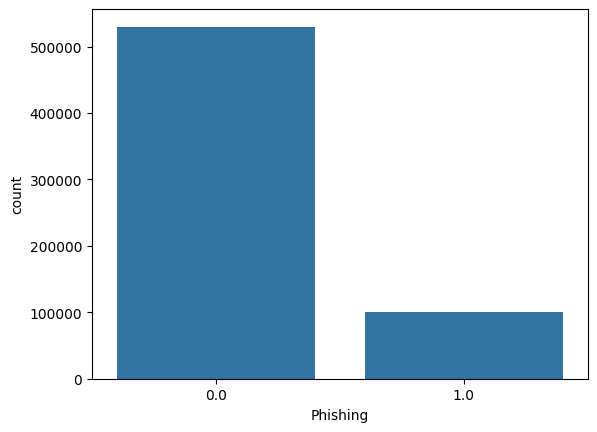

In [216]:
sns.countplot(data=dataset, x="Phishing")
plt.show()

In [217]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 630071 entries, 0 to 662590
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   NumDots          630071 non-null  int64  
 1   UrlLength        630071 non-null  int64  
 2   NumDash          630071 non-null  int64  
 3   AtSymbol         630071 non-null  int64  
 4   IpAddress        630071 non-null  int64  
 5   HttpsInHostname  630071 non-null  int64  
 6   PathLevel        630071 non-null  int64  
 7   PathLength       630071 non-null  int64  
 8   NumNumericChars  630071 non-null  int64  
 9   Phishing         630071 non-null  float64
dtypes: float64(1), int64(9)
memory usage: 52.9 MB


In [218]:
dataset.head()

,NumDots,UrlLength,NumDash,AtSymbol,IpAddress,HttpsInHostname,PathLevel,PathLength,NumNumericChars,Phishing
0,3,72,0,0,0,0,5,44,0,1.0
1,3,144,0,0,0,0,3,16,41,1.0
2,3,58,0,0,0,0,2,24,0,1.0
3,3,79,1,0,0,0,6,50,0,1.0
4,3,46,0,0,0,0,4,29,2,1.0


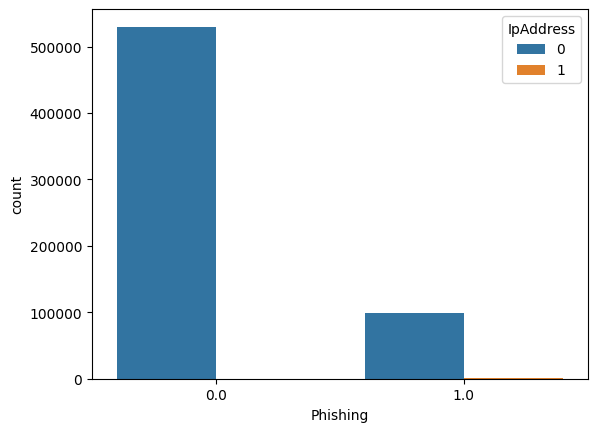

In [219]:
sns.countplot(data=dataset, x="Phishing", hue="IpAddress")
plt.show()

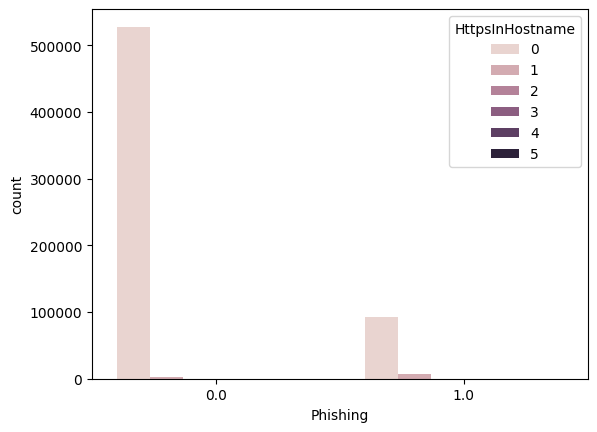

In [220]:
sns.countplot(data=dataset, x="Phishing", hue="HttpsInHostname")
plt.show()

Seems that the columns *'IpAddress'* and *'HttpsInHostname'* have no effect on the result.

In [221]:
dataset.drop(columns=['IpAddress', 'HttpsInHostname'], inplace=True)

dataset.head()

,NumDots,UrlLength,NumDash,AtSymbol,PathLevel,PathLength,NumNumericChars,Phishing
0,3,72,0,0,5,44,0,1.0
1,3,144,0,0,3,16,41,1.0
2,3,58,0,0,2,24,0,1.0
3,3,79,1,0,6,50,0,1.0
4,3,46,0,0,4,29,2,1.0


## Data preprocessing :

Splitting and scaling features :

In [222]:
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## The model :

In [223]:
model = Sequential([
    Dense(16, activation='relu', input_shape=(7,)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 16)                128       
                                                                 
 dense_43 (Dense)            (None, 8)                 136       
                                                                 
 dense_44 (Dense)            (None, 1)                 9         
                                                                 
Total params: 273 (1.07 KB)
Trainable params: 273 (1.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [229]:
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
15752/15752 [==============================] - 40s 3ms/step - loss: 0.3158 - accuracy: 0.8595
Epoch 2/10
15752/15752 [==============================] - 31s 2ms/step - loss: 0.3154 - accuracy: 0.8598
Epoch 3/10
15752/15752 [==============================] - 31s 2ms/step - loss: 0.3150 - accuracy: 0.8601
Epoch 4/10
15752/15752 [==============================] - 30s 2ms/step - loss: 0.3146 - accuracy: 0.8606
Epoch 5/10
15752/15752 [==============================] - 30s 2ms/step - loss: 0.3143 - accuracy: 0.8611
Epoch 6/10
15752/15752 [==============================] - 32s 2ms/step - loss: 0.3139 - accuracy: 0.8621
Epoch 7/10
15752/15752 [==============================] - 28s 2ms/step - loss: 0.3134 - accuracy: 0.8627
Epoch 8/10
15752/15752 [==============================] - 28s 2ms/step - loss: 0.3130 - accuracy: 0.8637
Epoch 9/10
15752/15752 [==============================] - 28s 2ms/step - loss: 0.3126 - accuracy: 0.8645
Epoch 10/10
15752/15752 [==============================

In [230]:
loss, accuracy = model.evaluate(X_test, y_test)
accuracy

3938/3938 [==============================] - 5s 1ms/step - loss: 0.3146 - accuracy: 0.8634


0.8634289503097534

3938/3938 [==============================] - 5s 1ms/step


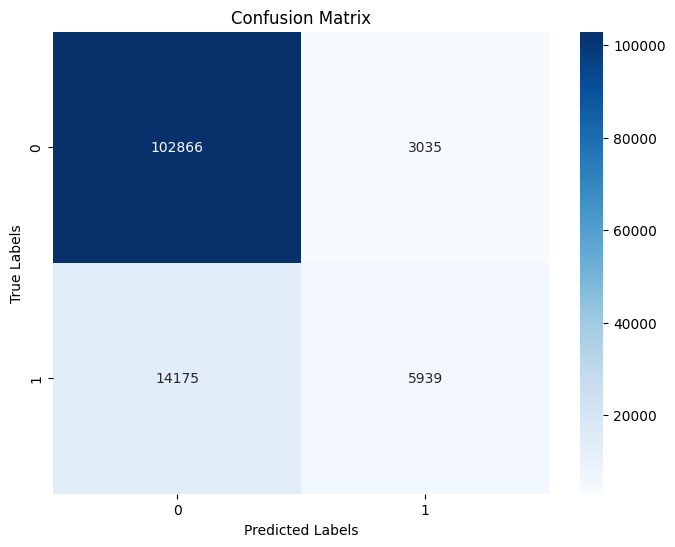

In [231]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [232]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92    105901
         1.0       0.66      0.30      0.41     20114

    accuracy                           0.86    126015
   macro avg       0.77      0.63      0.67    126015
weighted avg       0.84      0.86      0.84    126015



In [233]:
from google.colab import drive
drive.mount('/content/drive')

journal = pd.read_csv("/content/drive/MyDrive/datasets/malicious_phish1.csv")
journal.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [234]:
journal["type"].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [236]:
phishing_url = journal[journal["type"] == "phishing"].iloc[:, 0]
phishing_url.head()

0                                      br-icloud.com.br
21           signin.eby.de.zukruygxctzmmqi.civpro.co.za
28    http://www.marketingbyinternet.com/mo/e56508df...
40    https://docs.google.com/spreadsheet/viewform?f...
72                                 retajconsultancy.com
Name: url, dtype: object